# Causal Inference for Targeted Advertising: A Propensity Score Matching Analysis

## Introduction

In the digital advertising landscape, accurately measuring the effectiveness of ad campaigns is paramount. This project leverages causal inference techniques to assess the impact of a marketing campaign on user engagement within the context of the Criteo Uplift dataset. By quantifying the causal effect of exposure to an ad campaign on user visits and conversions, this analysis aims to inform targeted advertising strategies and optimize resource allocation.

## Methodology

This project follows a rigorous causal inference framework, combining statistical and machine learning approaches:

*   **Exploratory Data Analysis (EDA)**: Thorough investigation of user features and outcome variables to understand the underlying distributions and potential confounding factors.
*   **Propensity Score Matching (PSM)**: A technique to reduce selection bias by creating comparable treatment and control groups based on their propensity to be exposed to the ad campaign.
*   **Causal Effect Estimation**: Quantification of the average treatment effect on the treated (ATT) using both simple difference-in-means and logistic regression models.
*   **Statistical Significance Testing**: Assessment of the statistical significance of the estimated treatment effects to ensure the results are not due to chance.

In [1]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from causalml.match import NearestNeighborMatch
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.proportion import proportions_ztest
from sklearn.utils import resample

In [2]:
# Consistent style and colors
sns.set_style("whitegrid")
colors = sns.color_palette('crest', n_colors=6)

In [3]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/datasets/criteo-uplift-v2.1.csv')
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [4]:
print("Data Shape:", df.shape)
print("Data Types:\n", df.dtypes)

Data Shape: (13979592, 16)
Data Types:
 f0            float64
f1            float64
f2            float64
f3            float64
f4            float64
f5            float64
f6            float64
f7            float64
f8            float64
f9            float64
f10           float64
f11           float64
treatment       int64
conversion      int64
visit           int64
exposure        int64
dtype: object


## Exploratory Data Analysis (EDA)

We'll begin with an exploratory data analysis to understand the distribution of our treatment and control groups and examine any potential overlap in user features.

### Treatment vs. Control Group Distribution

Understanding the balance between the treatment (exposed to the ad campaign) and control (not exposed) groups is essential for causal inference. We'll visualize this distribution to check for any significant imbalances that might require adjustment.

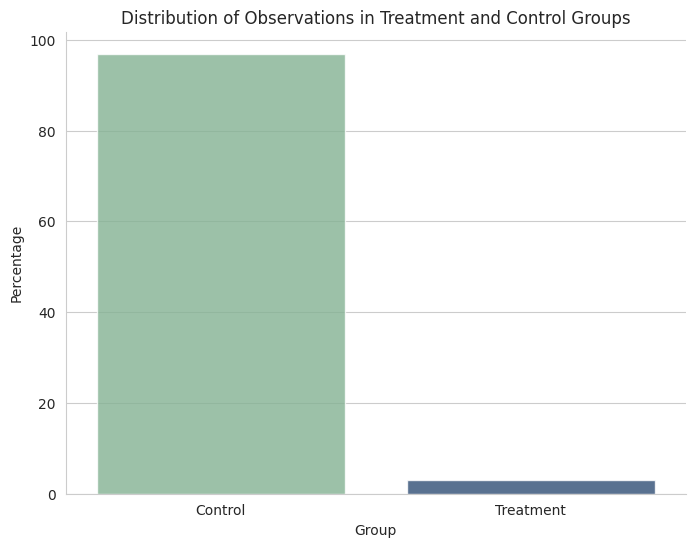

In [5]:
# Calculate exposure percentages
group_counts = df['exposure'].value_counts(normalize=True) * 100
group_counts = group_counts.reset_index()
group_counts.columns = ['exposure', 'percentage']

# Get colors
custom_colors = [colors[0], colors[5]]

# Create the count plot
plt.figure(figsize=(8, 6))
sns.barplot(x='exposure', y='percentage', hue='exposure', data=group_counts, palette=custom_colors, alpha=0.8, dodge=False)

# Customize the plot
plt.title('Distribution of Observations in Treatment and Control Groups')
plt.xlabel('Group')
plt.ylabel('Percentage')
plt.xticks(ticks=[0, 1], labels=['Control', 'Treatment'])

# Remove the legend since hue is only used to color the bars
plt.legend([], [], frameon=False)

# Remove the top and right spines
sns.despine()

# Show the plot
plt.show()

We see there is about 97% of data is from the control group and only 3% is from the treatment group. This imbalance can introduce bias into our analysis, as the treated group might not be representative of the overall population.

### Feature Overlap by Treatment Status

Next, we'll examine the **overlap** of user features between the treatment and control groups. This analysis will help us gauge the initial similarity of these groups based on their observable characteristics.

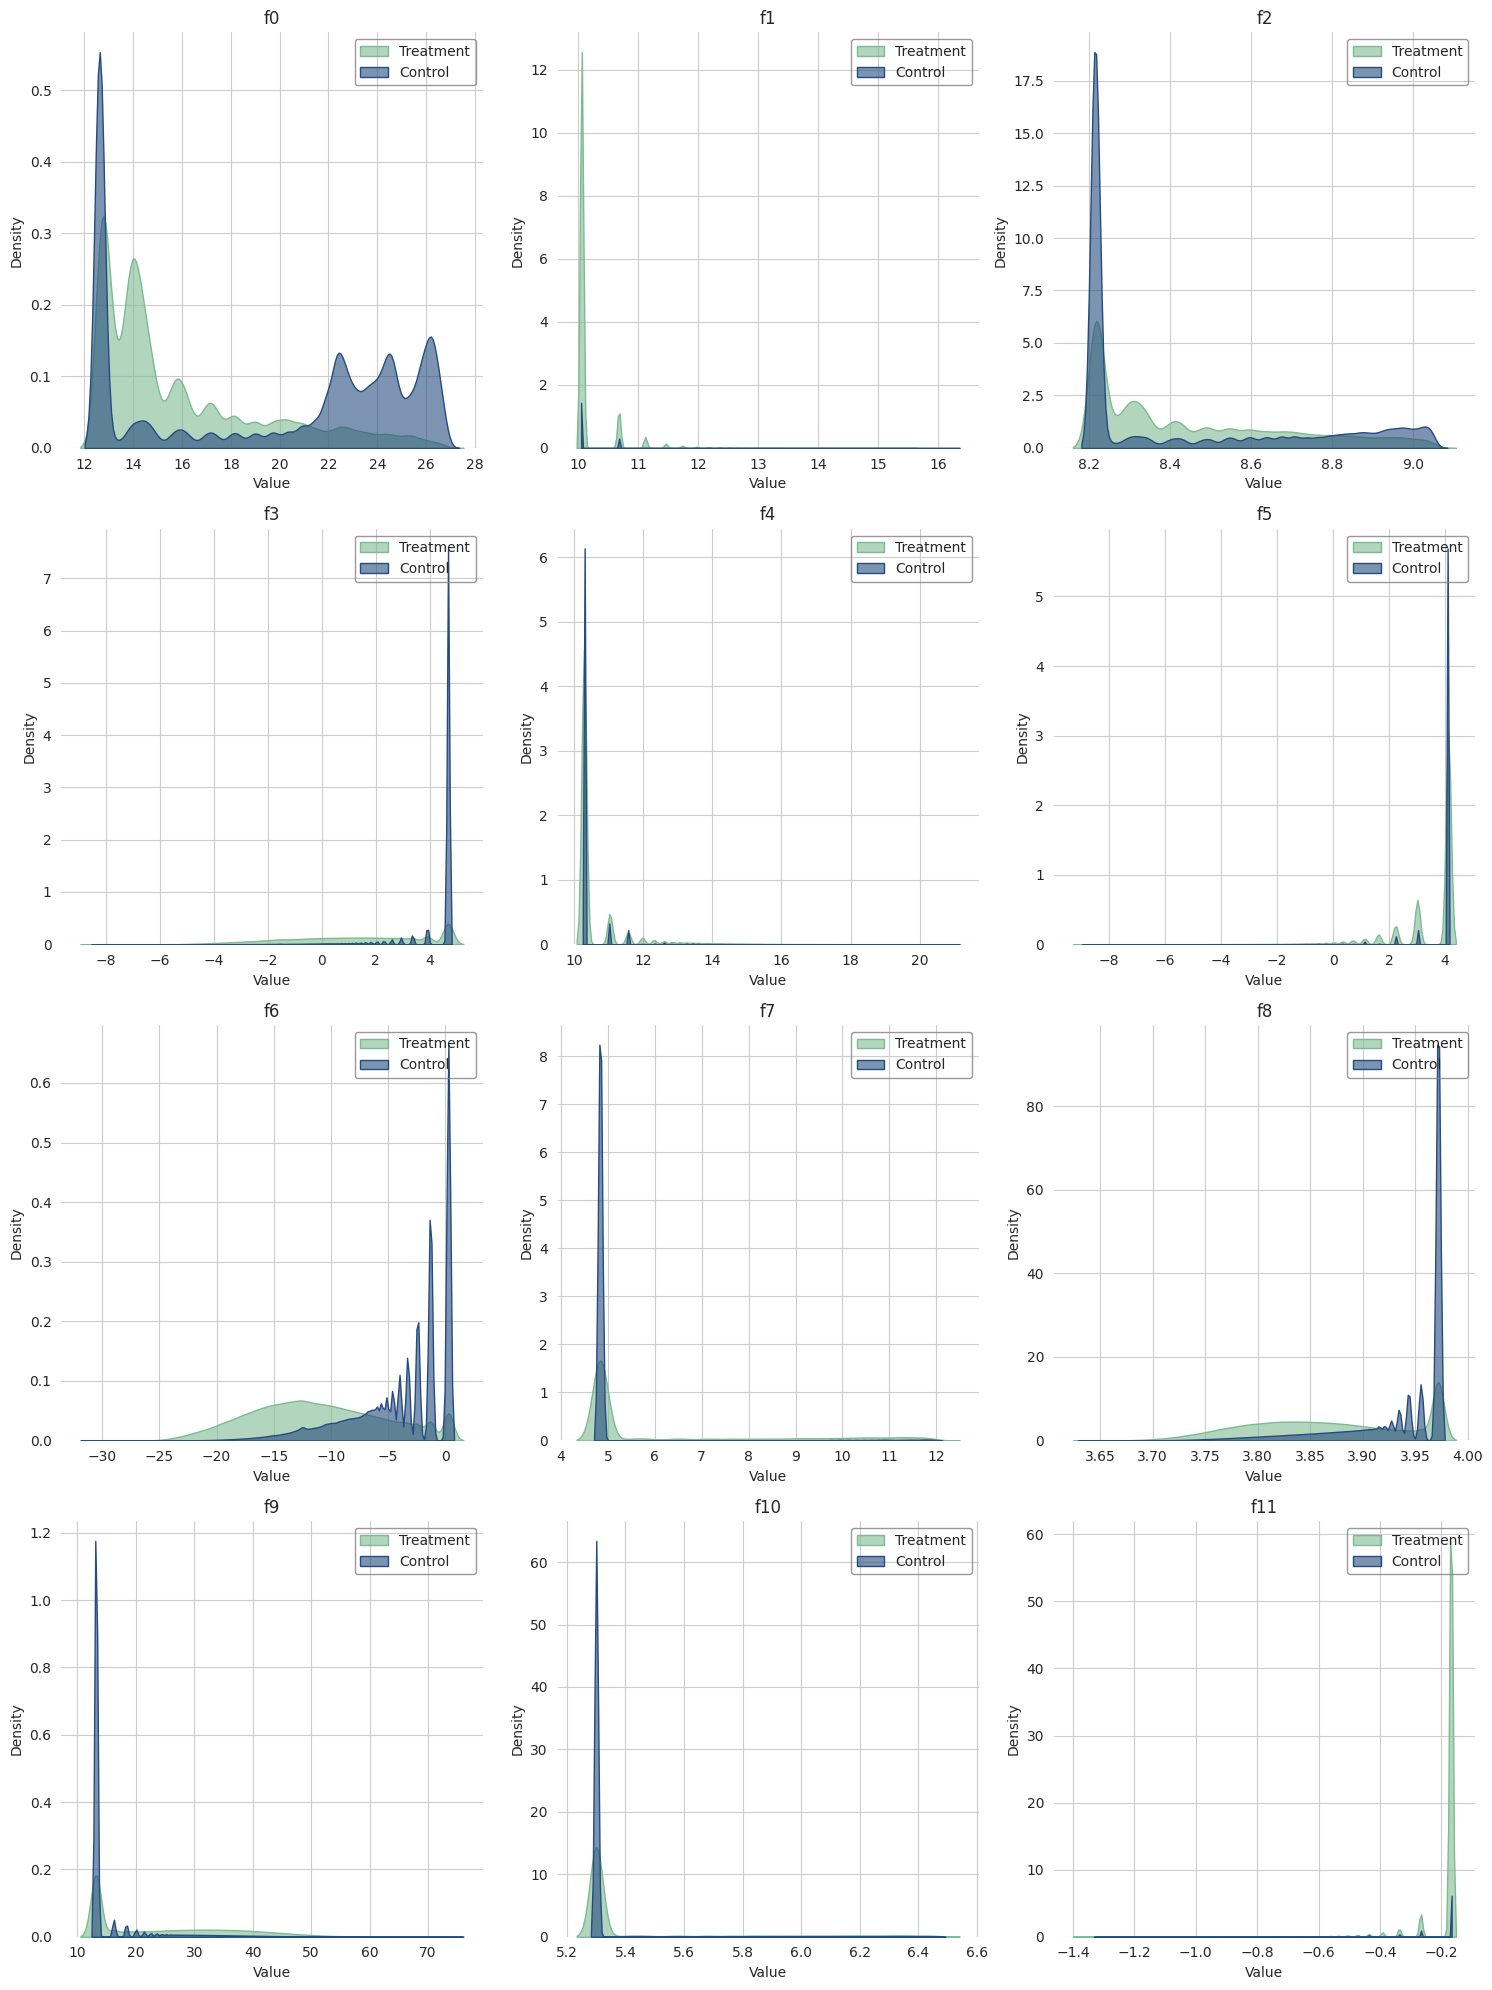

In [6]:
features = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']

# Create subplots
n_rows = 4
n_cols = 3
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 20))

# Iterate through each feature and create a KDE plot on its respective subplot
for i, feature in enumerate(features):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]

    # KDE plots for treatment and control groups, using colors from the defined palette
    sns.kdeplot(data=df[df['exposure'] == 1][feature], label='Treatment', fill=True, color=colors[0], alpha=0.6, ax=ax)
    sns.kdeplot(data=df[df['exposure'] == 0][feature], label='Control', fill=True, color=colors[5], alpha=0.6, ax=ax)

    # Customize the plot
    ax.set_title(feature)
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(facecolor='none')
    ax.get_legend().get_frame().set_edgecolor('grey')
    for spine in ['top', 'right', 'left', 'bottom']:
        ax.spines[spine].set_visible(False)

# Adjust layout to prevent overlapping elements
plt.tight_layout()
plt.show()

The plot reveals variations in feature distributions between the treatment and control groups. While there is overlap for most features, the range of values or the shape of the distributions differ in several instances. These discrepancies suggest potential imbalances between the groups that could bias our estimation of treatment effects. We will quantify these differences more rigorously in the next step using **Standardized Mean Differences (SMDs)**.

### Checking Covariate Balance: Standardized Mean Differences (SMD)

Standardized Mean Differences (SMD) provide a quantitative measure of the balance between treatment and control groups for each feature. Ideally, after matching, the SMD values should be close to zero, indicating that the groups are comparable across the features considered.


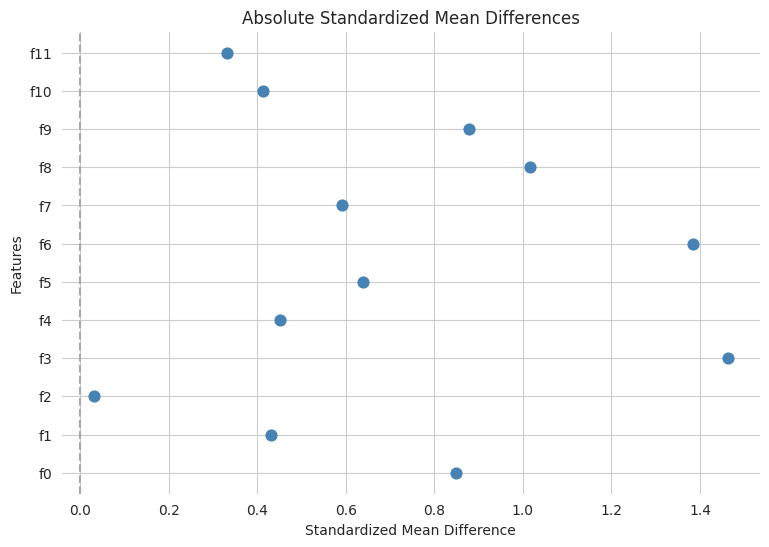

In [7]:
def calculate_smd(df, treatment_col, feature):
    treated = df[df[treatment_col] == 1][feature]
    control = df[df[treatment_col] == 0][feature]

    mean_treated = treated.mean()
    mean_control = control.mean()

    # Calculate the pooled standard deviation
    std_pooled = np.sqrt((treated.std() ** 2 + control.std() ** 2) / 2)

    smd = np.abs(mean_treated - mean_control) / std_pooled
    return smd

features = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']
smd_results = {feature: calculate_smd(df, 'exposure', feature) for feature in features}

plt.figure(figsize=(9, 6))
y_positions = range(len(features))
smd_values = [smd_results[feature] for feature in features]
plt.scatter(smd_values, y_positions, color='steelblue', s=60)
plt.yticks(y_positions, features)
plt.axvline(x=0, color='darkgrey', linestyle='--')
plt.xlabel('Standardized Mean Difference')
plt.ylabel('Features')
plt.title('Absolute Standardized Mean Differences')
for spine in ['top', 'right', 'left', 'bottom']:
    ax = plt.gca()
    ax.spines[spine].set_visible(False)
plt.show()

The initial SMD plot shows that there are substantial differences between the treatment and control groups across most features, except for f2. This underscores the need for **propensity score matching** to mitigate these imbalances and ensure a fair comparison of the groups.

## Propensity Score Matching (PSM)

Propensity Score Matching (PSM) is a statistical technique used to estimate the effect of a treatment by accounting for the covariates that predict receiving the treatment. In this case, we use PSM to create a control group that is similar to the treatment group in terms of their propensity to be exposed to the ad campaign.

### Propensity Score Estimation

We will use logistic regression to estimate the propensity score, which represents the probability of a user being exposed to the treatment (ad campaign) given their observed characteristics. The features collected in the dataset will serve as predictors in the logistic regression model.

In [8]:
# Standardize features for better logistic regression convergence
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])
y = df['exposure']

# Estimate Propensity Scores (Increased max_iter for better convergence)
logistic = LogisticRegression(max_iter=500)
logistic.fit(X_scaled, y)
df['propensity_score'] = logistic.predict_proba(X_scaled)[:, 1]

The propensity score for each user is calculated based on their feature values, representing their likelihood of being in the treatment group.

### Nearest Neighbor Matching

Using the estimated propensity scores, we will apply nearest neighbor matching to pair treated and control users who have similar propensity scores. This aims to create a balanced dataset where the treatment and control groups are comparable across the measured covariates.

In [9]:
# Nearest Neighbor Matching
matcher = NearestNeighborMatch(replace=True, ratio=1, random_state=0)
matched_data = matcher.match(data=df, treatment_col='exposure', score_cols=['propensity_score'])

matched_data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure,propensity_score
540,12.896938,10.059654,8.214383,3.359763,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,1,0.025425
548,16.689925,10.059654,8.214383,1.267425,10.280525,4.115453,-6.699321,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,1,0.036953
715,12.781566,10.059654,8.215920,1.114982,11.561050,4.115453,-7.011752,4.833815,3.799079,45.054671,5.303177,-0.337358,1,1,1,1,0.204294
808,13.018571,10.059654,8.301697,-0.413110,10.280525,4.115453,-10.143546,4.833815,3.876391,30.796373,5.300375,-0.168679,1,0,1,1,0.205899
823,12.704505,10.059654,8.214383,0.604065,10.280525,4.115453,-8.058865,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,1,0.090552


The `matched_data` DataFrame now contains pairs of treated and control users who have been matched based on their propensity scores, effectively reducing the selection bias in the dataset.

### Plot Propensity Score Distribution After Matching

Visualizing the distribution of propensity scores for the treatment and control groups after matching is an important step to assess the effectiveness of the matching procedure. If matching is successful, the distributions should be similar, indicating that the groups are balanced in terms of their propensity to be treated.

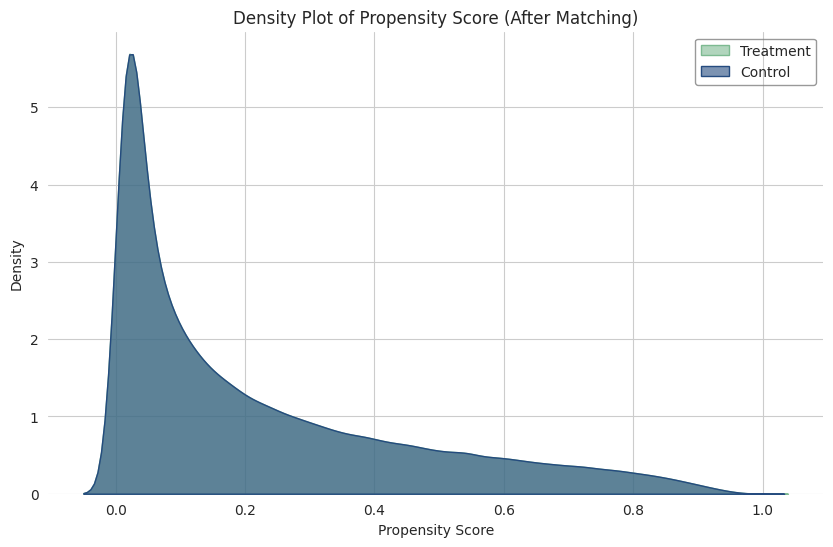

In [10]:
plt.figure(figsize=(10, 6))
ax = sns.kdeplot(data=matched_data[matched_data['exposure'] == 1]['propensity_score'], label='Treatment', fill=True, color=colors[0], alpha=0.6)
sns.kdeplot(data=matched_data[matched_data['exposure'] == 0]['propensity_score'], label='Control', fill=True, color=colors[5], alpha=0.6)
plt.title('Density Plot of Propensity Score (After Matching)')
plt.xlabel('Propensity Score')
plt.ylabel('Density')

# Set legend with transparent background
leg = plt.legend(facecolor='none')
leg.get_frame().set_edgecolor('grey')

# Remove the outer spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.show()

The overlapping density curves of the propensity scores after matching indicate a successful balancing of the treatment and control groups. This suggests that the matched groups are now more comparable in terms of their likelihood of receiving the treatment, reducing the potential for confounding bias in our causal effect estimates.

### Calculate and Plot SMDs After Matching

We'll re-calculate the standardized mean differences (SMDs) after matching and visualize them to assess the extent to which the matching process has balanced the covariates between the groups.

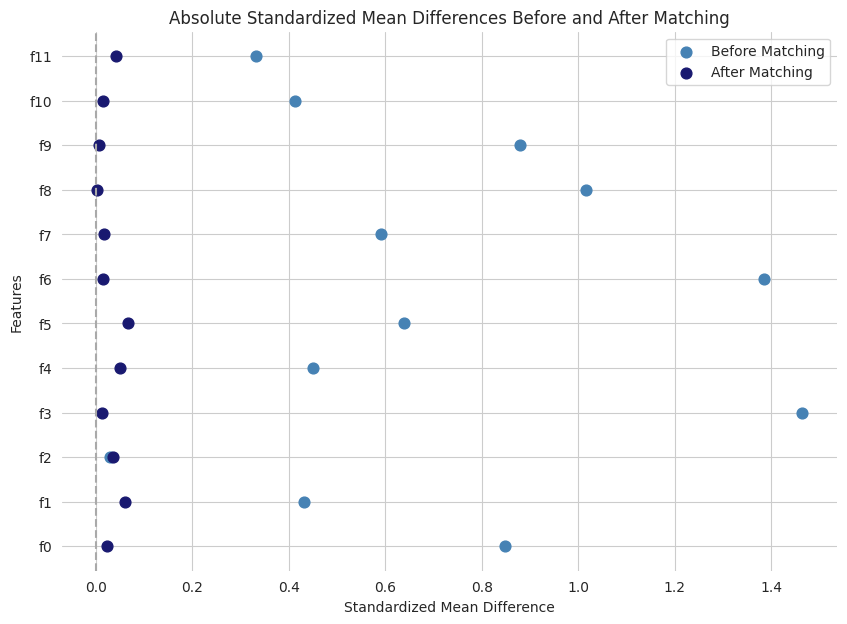

In [11]:
smd_results_after = {feature: calculate_smd(matched_data, 'exposure', feature) for feature in features}

# Visualize SMD before and after matching
plt.figure(figsize=(10, 7))
y_positions = range(len(features))
plt.scatter(smd_values, y_positions, color='steelblue', s=60, label='Before Matching')
plt.scatter(smd_results_after.values(), y_positions, color='midnightblue', s=60, label='After Matching')
plt.yticks(y_positions, features)
plt.axvline(x=0, color='darkgrey', linestyle='--')
plt.xlabel('Standardized Mean Difference')
plt.ylabel('Features')
plt.title('Absolute Standardized Mean Differences Before and After Matching')
plt.legend()
for spine in ['top', 'right', 'left', 'bottom']:
    ax = plt.gca()
    ax.spines[spine].set_visible(False)
plt.show()

The SMD plot after matching demonstrates a substantial reduction in the standardized mean differences across all features. This suggests that the propensity score matching has been effective in balancing the treatment and control groups, making them more comparable for causal effect estimation.

## Estimating the Average Treatment Effect on the Treated (ATT)

Now that we have a balanced dataset, we can proceed to estimate the causal effect of the treatment (exposure to the ad campaign) on the outcomes of interest (visit and conversion).

### Calculate ATT Using Simple Difference in Means

A straightforward method for estimating the ATT is to calculate the simple difference in means between the outcomes of the treated and control groups after matching.

In [12]:
def calculate_att_simple(matched_data, treatment_col, outcome_col):
    treated_data = matched_data[matched_data[treatment_col] == 1]
    control_data = matched_data[matched_data[treatment_col] == 0]
    att = treated_data[outcome_col].mean() - control_data[outcome_col].mean()
    return att

# Calculate and print ATT for 'visit' and 'conversion' using simple difference in means
att_visit_simple = calculate_att_simple(matched_data, 'exposure', 'visit')
att_conversion_simple = calculate_att_simple(matched_data, 'exposure', 'conversion')
print(f"ATT for visit (simple): {att_visit_simple:.4f}")
print(f"ATT for conversion (simple): {att_conversion_simple:.4f}")

ATT for visit (simple): 0.2586
ATT for conversion (simple): 0.0430


The **ATT** estimates indicate the average difference in the visit and conversion rates between the treated and control groups. The positive ATT for both **visits (0.2586)** and **conversions (0.0430)** suggests that the ad campaign has a positive impact on both outcomes. However, we need to assess statistical significance to confirm these findings.

### Perform Z-Test for Proportions

To determine whether the observed differences in visit and conversion rates are statistically significant, we'll perform a Z-test for proportions. This test will help us assess whether the observed differences are likely due to chance or a genuine effect of the treatment.

In [13]:
# Calculate counts and perform Z-test for 'visit'
count_visit = np.array([
    matched_data[matched_data['exposure'] == 1]['visit'].sum(),
    matched_data[matched_data['exposure'] == 0]['visit'].sum()
])
nobs_visit = np.array([
    (matched_data['exposure'] == 1).sum(),
    (matched_data['exposure'] == 0).sum()
])
_, pval_visit = proportions_ztest(count_visit, nobs_visit)
print(f"P-value for visit: {pval_visit:.4f}")

# Check significance for 'visit'
alpha = 0.05
if pval_visit < alpha:
    print("The ATT for visit is statistically significant.")
else:
    print("The ATT for visit is not statistically significant.")

# Calculate counts and perform Z-test for 'conversion'
count_conversion = np.array([
    matched_data[matched_data['exposure'] == 1]['conversion'].sum(),
    matched_data[matched_data['exposure'] == 0]['conversion'].sum()
])
nobs_conversion = np.array([
    (matched_data['exposure'] == 1).sum(),
    (matched_data['exposure'] == 0).sum()
])
_, pval_conversion = proportions_ztest(count_conversion, nobs_conversion)
print(f"P-value for conversion: {pval_conversion:.4f}")

# Check significance for 'conversion'
if pval_conversion < alpha:
    print("The ATT for conversion is statistically significant.")
else:
    print("The ATT for conversion is not statistically significant.")

P-value for visit: 0.0000
The ATT for visit is statistically significant.
P-value for conversion: 0.0000
The ATT for conversion is statistically significant.


The **p-values** for both **visits (0.0000)** and **conversions (0.0000)** are well below the significance level of 0.05. This provides strong evidence that the observed differences in visit and conversion rates are not due to chance and are statistically significant.

### Calculate ATT Using Logistic Regression and Bootstrapping

While the simple difference-in-means provides an initial estimate of the ATT, logistic regression can offer a more refined approach by modeling the relationship between exposure and outcomes while controlling for other features. Bootstrapping will provide a measure of uncertainty (standard error) and allow us to construct confidence intervals for the ATT.

In [14]:
def calculate_att_logistic(matched_data, features, outcome_col, bootstrap_samples=1000):
    X = matched_data[['exposure'] + features]
    y = matched_data[outcome_col]
    model = LogisticRegression(solver='liblinear', max_iter=200)
    model.fit(X, y)

    treated = matched_data[matched_data['exposure'] == 1]
    control_features = treated.copy()
    control_features['exposure'] = 0
    prob_treated = model.predict_proba(treated[X.columns])[:, 1]
    prob_control = model.predict_proba(control_features[X.columns])[:, 1]

    att = np.mean(prob_treated - prob_control)

    # Bootstrap for standard error estimation and confidence interval
    bootstrapped_atts = []
    for _ in range(bootstrap_samples):
        sample = resample(treated, replace=True)
        control_features_sample = sample.copy()
        control_features_sample['exposure'] = 0
        prob_treated_sample = model.predict_proba(sample[X.columns])[:, 1]
        prob_control_sample = model.predict_proba(control_features_sample[X.columns])[:, 1]
        bootstrapped_atts.append(np.mean(prob_treated_sample - prob_control_sample))
    std_error = np.std(bootstrapped_atts)
    ci_lower = att - 1.96 * std_error
    ci_upper = att + 1.96 * std_error

    return att, std_error, ci_lower, ci_upper

# Calculate and print ATT for 'visit' and 'conversion' using logistic regression
att_visit_logistic, std_error_visit, ci_lower_visit, ci_upper_visit = calculate_att_logistic(matched_data, features, 'visit')
att_conversion_logistic, std_error_conversion, ci_lower_conversion, ci_upper_conversion = calculate_att_logistic(matched_data, features, 'conversion')

print(f"ATT for visit (logistic): {att_visit_logistic:.4f} (SE: {std_error_visit:.4f}, 95% CI: [{ci_lower_visit:.4f}, {ci_upper_visit:.4f}])")
print(f"ATT for conversion (logistic): {att_conversion_logistic:.4f} (SE: {std_error_conversion:.4f}, 95% CI: [{ci_lower_conversion:.4f}, {ci_upper_conversion:.4f}])")

ATT for visit (logistic): 0.2671 (SE: 0.0002, 95% CI: [0.2667, 0.2675])
ATT for conversion (logistic): 0.0427 (SE: 0.0001, 95% CI: [0.0425, 0.0429])


The **ATT** estimates from the logistic regression model further confirm the positive impact of the ad campaign on **visits (0.2671)** and **conversions (0.0427)**. The tight confidence intervals around these estimates indicate a high level of precision in our findings.

## Causal Assumptions

The robustness of our causal conclusions hinges upon the validity of several key assumptions:

*   **Stable Unit Treatment Value Assumption (SUTVA)**: We assume that the outcome of one user is not affected by whether another user is exposed to the ad campaign.
*  **Ignorability**: After controlling for the observed covariates through propensity score matching, we assume that the treatment assignment is independent of the potential outcomes. This implies that there are no unobserved factors that jointly influence both the exposure to the ad campaign and the outcome variables (visits and conversions).
*   **Overlap**: We assume that for every combination of observed covariates, there is a non-zero probability of being assigned to either the treatment or control group. This ensures that we can find valid matches for each treated individual.
*   **Correct Specification of the Propensity Score Model**: We assume that the logistic regression model used to estimate propensity scores is correctly specified, meaning it captures all relevant covariates that influence treatment assignment.
*   **Consistency**: We assume that the potential outcome under treatment (ad exposure) is equal to the observed outcome for individuals who were actually treated.

## Conclusion

This analysis demonstrates that the targeted ad campaign has a statistically significant positive causal effect on both user visits and conversions assuming that the required causal assumptions hold.

Specifically, our logistic regression models, combined with propensity score matching and bootstrapping, estimate that **exposure to the ad campaign increases the probability of a user visiting the site by approximately 26.71%** (95% CI: [26.67%, 26.75%]) **and the probability of conversion by approximately 4.27%** (95% CI: [4.25%, 4.29%]). These results are robust to statistical significance testing, indicating that the observed effects are unlikely due to chance.

### Save Matched Data

Lastly, we save the matched data for further investigation on the heterogeneous treatment effect for segmentation.

In [15]:
# Write the DataFrame to a CSV file
matched_data.to_csv('/content/drive/MyDrive/datasets/matched_data.csv', index=False)